In [ ]:
#
# Initialization
#
import os
import sys

import ipynbname
from pathlib import Path

# Set notebook's src module path. Note that you may have to update your IDE's project settings to do the same for the
#  local library imports to work the same
MODULE_PATH = ipynbname.path().parent.parent
sys.path.append(str(MODULE_PATH))

# Keep paths consistent throughout notebook
os.chdir(MODULE_PATH)

# This should always be `./src`
print(f"Current working directory [{os.getcwd()}]")

# Place all local artifacts in a disposable, git-ignored directory
local_artifact_dir = Path(os.getcwd()).parent / "out"
local_artifact_dir.mkdir(parents=True, exist_ok=True)

# Autoreload imports at the beginning of cell execution.
#  https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
#
# Setup utils
#

import subprocess

from utils.logger_util import LoggerUtil
from utils.utils import Utils
from utils import config

LOGGER = LoggerUtil(config.MODEL_ID, local_artifact_dir / "logs")
UTILS = Utils(LOGGER)

UTILS.describe_env()

# AWS instance specs can be found here https://aws.amazon.com/sagemaker/pricing/
AWS_INSTANCE = 'ml.m5.large' # 2 vCPU, 0 GPU, 8 GB memory, $0.134/hour
AWS_INSTANCE_2 = 'ml.m5.4xlarge' # 8 vCPU, 0 GPU, 32 GB memory, $0.538/hour
AWS_GPU_INSTANCE = 'ml.g4dn.xlarge' # 4 vCPU, 1 GPU, 16 GB memory, $0.736/hour
AWS_GPU_INSTANCE_2 = 'ml.g4dn.2xlarge' # 8 vCPU, 1 GPU, 32 GB memory, $1.053/hour
LOCAL_INSTANCE = 'local'
try:
    if subprocess.call('nvidia-smi') == 0:
        LOCAL_INSTANCE = 'local_gpu'
except:
    LOGGER.log("The nvidia-smi binary was not found and thus GPU computation is not supported. Using the default CPU "
               "computation")

# Change this to your desired instance type
INSTANCE_TYPE = LOCAL_INSTANCE
IS_LOCAL = LOCAL_INSTANCE == INSTANCE_TYPE

2021-05-09 21:51:05.805337 Background logger started
2021-05-09 21:51:05.805980 The model id is [giia-0.5.8]
2021-05-09 21:51:05.806097 The MXNet version is [1.7.0]
2021-05-09 21:51:05.806331 The GluonTS version is [0.7.1.dev3+gecb903f]
2021-05-09 21:51:05.806446 The GPU count is [0]
2021-05-09 21:51:05.812863 The nvidia-smi binary was not found and thus GPU computation is not supported. Using the default CPU computation


In [3]:
#
# Parse dataset
#

from data_processing.parse import Parse

PARSE = Parse(LOGGER)

dataset_dir_path = local_artifact_dir / "datasets"

# Creates train and test dataset CSVs
PARSE.split_train_test_dataset(dataset_dir_path)

Number of momentum_indicator: 9
Number of overlap_studies: 1
Number of pattern_recognition: 2
Number of volume_bin: 1
2021-05-09 21:51:37.916866 First sample:
2021-05-09 21:51:37.924199 
              open    high     low   close     volume        mfi       roc  \
date                                                                         
2021-01-01  736.42  737.09  735.94  737.02  647.71994  67.016654 -0.024417   

                  adx        rsi      slowd      slowk     macd  macdsignal  \
date                                                                          
2021-01-01  41.517721  48.978247  28.422228  36.793794 -0.39571   -0.524754   

            macdhist         hma  pattern_count  pattern_detected volume_bin  
date                                                                          
2021-01-01  0.129044  736.669073              1                63          1  
2021-05-09 21:51:37.924743 Last sample:
2021-05-09 21:51:37.930919 
                        open     hi

In [ ]:
#
# Setup local/aws environment. If aws, upload the datasets to S3
#

from data_processing.aws_handler import AWSHandler
from sagemaker import LocalSession

AWS_HANDLER = AWSHandler(LOGGER, config.MODEL_ID)

sagemaker_session = None

model_output_dir_path = local_artifact_dir / config.MODEL_ID / "models"
model_output_dir_path.mkdir(parents=True, exist_ok=True)

if IS_LOCAL:
    LOGGER.log("Notebook is set to local mode, not uploading to S3")

    dataset_dir_uri = f"file://{dataset_dir_path}"
    model_output_dir_uri = f"file://{model_output_dir_path}"

    sagemaker_session = LocalSession()
    sagemaker_session.config = {
        'local': {
            'local_code': True,
            'container_root': str(model_output_dir_path)
        }
    }
else:
    sagemaker_session = AWS_HANDLER.sagemaker_session

    AWS_HANDLER.upload_train_datasets(dataset_dir_path)
    dataset_dir_uri = AWS_HANDLER.s3_dataset_dir_uri

    model_output_dir_uri = AWS_HANDLER.s3_model_output_uri

LOGGER.log(f"Model output dir is [{model_output_dir_uri}]")

In [ ]:
#
# Configure sagemaker and estimator
#

from ml.train import Train

TRAIN = Train(LOGGER)

if IS_LOCAL:
    train_kwargs = {}
else:
    train_kwargs = {
        # 'checkpoint_s3_uri': model_output_dir_uri,
        'output_path': model_output_dir_uri,
        'code_location': model_output_dir_uri,
        'use_spot_instances': True,
        'max_wait': 18 * 60 * 60, # 18 hours
        'max_run': 18 * 60 * 60, # 18 hours
    }

estimator = TRAIN.create_model(config.SM_ROLE, INSTANCE_TYPE, sagemaker_session, train_kwargs)
TRAIN.fit_model(estimator, dataset_dir_uri)

In [8]:
#
# Load model
#

import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice
from gluonts.model.predictor import Predictor

if IS_LOCAL:
    # model_output_dir_path is basically the same path as it was before, though sagemaker appends a random temp
    # directory to the path. The path from TRAIN includes that random temp directory
    # model_dir_path = TRAIN.model_data_path.parent.parent / "model"
    model_dir_path = local_artifact_dir / "local_cli" / "model"
else:
    model_dir_path = AWS_HANDLER.download_model_from_s3(str(TRAIN.model_data_path), local_artifact_dir)

LOGGER.log(f"Model dir is [{model_dir_path}]")
predictor = Predictor.deserialize(model_dir_path)
LOGGER.log(f"Predictor metadata [{predictor.__dict__}]")


def plot_prob_forecasts(ts_list, forecast_list, plot_length=100):
    for target, forecast in islice(zip(ts_list, forecast_list), len(forecast_list)):
        prediction_intervals = (50.0, 90.0)
        legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        ax = target[-plot_length:].plot(figsize=(10, 7), linewidth=2)
        forecast.plot(prediction_intervals=prediction_intervals, color='g')
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.show()
    
def plot_prob_forecasts_multi(ts_list, forecast_list, plot_length=60):
    for target, forecast in islice(zip(ts_list, forecast_list), len(forecast_list)):
        for i in range(5):
            prediction_intervals = (50.0, 90.0)
            legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
            fig, ax = plt.subplots(1, 1, figsize=(10, 7))
            target[i][-plot_length:].plot(ax=ax)  # plot the time series
            forecast.copy_dim(i).plot(prediction_intervals=prediction_intervals, color='g')
            plt.grid(which="both")
            plt.legend(legend, loc="upper left")
            plt.show()

2021-05-10 08:37:57.651212 Model dir is [/Users/jbeckman/projects/capia/out/local_cli/model]
2021-05-10 08:37:57.664857 Predictor metadata [{'prediction_length': 5, 'freq': '1min', 'lead_time': 0, 'input_names': ['feat_static_cat', 'feat_static_real', 'past_time_feat', 'past_target', 'past_observed_values', 'future_time_feat', 'past_is_pad'], 'prediction_net': gluonts.model.deepar._network.DeepARPredictionNetwork(cardinality=[1], cell_type="lstm", context_length=60, default_scale=None, distr_output=gluonts.mx.distribution.neg_binomial.NegativeBinomialOutput(), dropout_rate=0.1, dropoutcell_type="ZoneoutCell", dtype=numpy.float32, embedding_dimension=[1], history_length=242, impute_missing_values=False, lags_seq=[1, 2, 3, 4, 5, 6, 7, 58, 59, 60, 61, 62, 118, 119, 120, 121, 122, 178, 179, 180, 181, 182], minimum_scale=1e-10, num_cells=40, num_imputation_samples=1, num_layers=2, num_parallel_samples=100, prediction_length=5, scaling=True), 'batch_size': 32, 'input_transform': gluonts.tran

In [9]:
#
# Define test data and make a prediction
#

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset, FileDataset
from utils.splitter import DateSplitter
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.stat import calculate_dataset_statistics

# test_file_dataset = FileDataset(path=(dataset_dir_path / config.TEST_DATASET_FILENAME).parent, freq="min")
test_file_dataset = FileDataset(path=(dataset_dir_path / config.TEST_DATASET_FILENAME).parent, freq=config.DATASET_FREQ)

# pd.Timedelta(config.HYPER_PARAMETERS["prediction_length"], unit="5min")
# for data in iter(test_file_dataset):
#     data.start.freqstr = "min"

test_datasets = []
test_dates = ["2021-04-20 12:50:00", "2021-04-20 15:55:00", "2021-04-21 16:00:00", "2021-04-22 17:00:00"]
for idx, date in enumerate(test_dates):
    # 1) Get splice of dataset for different dates with ample history
    splitter = DateSplitter(
        prediction_length=-config.HYPER_PARAMETERS["prediction_length"],
        split_date=date,
        max_history=config.FREQTRADE_MAX_CONTEXT
    )
    (_, train_dataset), (_, test_dataset) = splitter.split(test_file_dataset)

    # # 2) Remove other time-series as we only want to predict
    # for data in iter(test_dataset):
    #     if data['item_id'] == "close":
    #         test_dataset = ListDataset([{
    #             FieldName.START: data[FieldName.START],
    #             FieldName.TARGET: data[FieldName.TARGET],
    #             FieldName.FEAT_STATIC_CAT: data[FieldName.FEAT_STATIC_CAT],
    #             FieldName.ITEM_ID: data[FieldName.ITEM_ID],
    #         }], freq=config.DATASET_FREQ)
    #         break

    LOGGER.log(f"Test dataset [{idx}] stats: {calculate_dataset_statistics(test_dataset)}")
    test_datasets.append(test_dataset)

100%|██████████| 1/1 [00:00<00:00, 1865.79it/s]


2021-05-10 08:38:01.324969 Test dataset [0] stats: DatasetStatistics(integer_dataset=False, max_target=2198.590087890625, mean_abs_target=2137.0067635270543, mean_target=2137.0067635270543, mean_target_length=499.0, max_target_length=499, min_target=2057.3798828125, feat_static_real=[], feat_static_cat=[], num_past_feat_dynamic_real=0, num_feat_dynamic_real=16, num_feat_dynamic_cat=0, num_missing_values=0, num_time_observations=499, num_time_series=1, scale_histogram=gluonts.dataset.stat.ScaleHistogram(base=2.0, bin_counts={11: 1}, empty_target_count=0))
2021-05-10 08:38:01.472458 Test dataset [1] stats: DatasetStatistics(integer_dataset=False, max_target=2228.169921875, mean_abs_target=2166.3602204408817, mean_target=2166.3602204408817, mean_target_length=499.0, max_target_length=499, min_target=2057.739990234375, feat_static_real=[], feat_static_cat=[], num_past_feat_dynamic_real=0, num_feat_dynamic_real=16, num_feat_dynamic_cat=0, num_missing_values=0, num_time_observations=499, num

100%|██████████| 1/1 [00:00<00:00, 1736.05it/s]

2021-05-10 08:38:01.692031 Test dataset [2] stats: DatasetStatistics(integer_dataset=False, max_target=2446.550048828125, mean_abs_target=2330.0450901803606, mean_target=2330.0450901803606, mean_target_length=499.0, max_target_length=499, min_target=2237.3798828125, feat_static_real=[], feat_static_cat=[], num_past_feat_dynamic_real=0, num_feat_dynamic_real=16, num_feat_dynamic_cat=0, num_missing_values=0, num_time_observations=499, num_time_series=1, scale_histogram=gluonts.dataset.stat.ScaleHistogram(base=2.0, bin_counts={11: 1}, empty_target_count=0))
2021-05-10 08:38:01.883939 Test dataset [3] stats: DatasetStatistics(integer_dataset=False, max_target=2640.0, mean_abs_target=2549.8517034068136, mean_target=2549.8517034068136, mean_target_length=499.0, max_target_length=499, min_target=2418.2099609375, feat_static_real=[], feat_static_cat=[], num_past_feat_dynamic_real=0, num_feat_dynamic_real=16, num_feat_dynamic_cat=0, num_missing_values=0, num_time_observations=499, num_time_seri

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


2021-05-10 08:38:06.226894 {
    "MSE": 103.39449462890624,
    "abs_error": 46.5,
    "abs_target_sum": 10857.919921875,
    "abs_target_mean": 2171.583984375,
    "seasonal_error": 2.7401333512931036,
    "MASE": 3.393995403767927,
    "MAPE": 0.004284869879484177,
    "sMAPE": 0.004272094741463661,
    "OWA": NaN,
    "MSIS": 66.63909255140037,
    "QuantileLoss[0.1]": 50.183984375,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 46.5,
    "Coverage[0.5]": 0.8,
    "QuantileLoss[0.9]": 66.81601562499999,
    "Coverage[0.9]": 1.0,
    "RMSE": 10.168308346470727,
    "NRMSE": 0.004682438450289663,
    "ND": 0.004282588224501304,
    "wQuantileLoss[0.1]": 0.004621878291245859,
    "wQuantileLoss[0.5]": 0.004282588224501304,
    "wQuantileLoss[0.9]": 0.00615366627362839,
    "mean_absolute_QuantileLoss": 54.5,
    "mean_wQuantileLoss": 0.005019377596458517,
    "MAE_Coverage": 0.16666666666666666
}


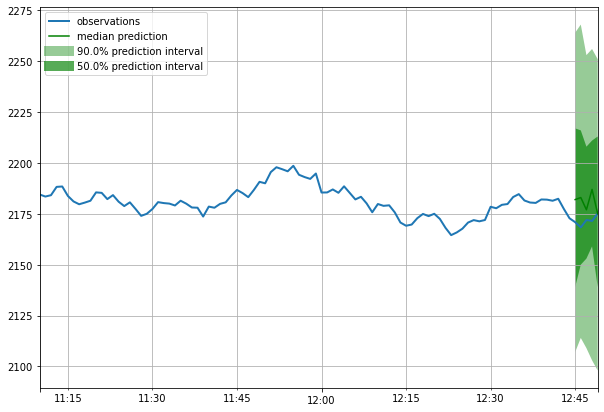

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


2021-05-10 08:38:07.379193 {
    "MSE": 19.491346740722655,
    "abs_error": 25.5,
    "abs_target_sum": 10836.5,
    "abs_target_mean": 2167.3,
    "seasonal_error": 2.686688343845081,
    "MASE": 1.8982477114189893,
    "MAPE": 0.0023529347032308578,
    "sMAPE": 0.002356591634452343,
    "OWA": NaN,
    "MSIS": 70.04906260569682,
    "QuantileLoss[0.1]": 61.099999999999994,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 25.5,
    "Coverage[0.5]": 0.0,
    "QuantileLoss[0.9]": 57.69999999999999,
    "Coverage[0.9]": 1.0,
    "RMSE": 4.414900535767782,
    "NRMSE": 0.0020370509554596882,
    "ND": 0.002353158307571633,
    "wQuantileLoss[0.1]": 0.00563835186637752,
    "wQuantileLoss[0.5]": 0.002353158307571633,
    "wQuantileLoss[0.9]": 0.005324597425367969,
    "mean_absolute_QuantileLoss": 48.099999999999994,
    "mean_wQuantileLoss": 0.004438702533105707,
    "MAE_Coverage": 0.2333333333333333
}


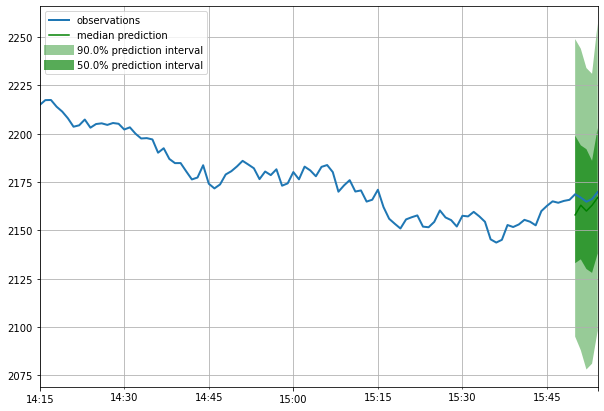

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


2021-05-10 08:38:08.402486 {
    "MSE": 317.3091552734375,
    "abs_error": 69.239990234375,
    "abs_target_sum": 12201.240234375,
    "abs_target_mean": 2440.248046875,
    "seasonal_error": 3.3024575502345335,
    "MASE": 4.193240287340422,
    "MAPE": 0.0056730836629867555,
    "sMAPE": 0.0056919768452644345,
    "OWA": NaN,
    "MSIS": 56.987863473562115,
    "QuantileLoss[0.1]": 78.24799804687501,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 69.239990234375,
    "Coverage[0.5]": 0.0,
    "QuantileLoss[0.9]": 42.55200195312499,
    "Coverage[0.9]": 1.0,
    "RMSE": 17.813173644060104,
    "NRMSE": 0.007299738920751023,
    "ND": 0.00567483214036739,
    "wQuantileLoss[0.1]": 0.0064131183833610675,
    "wQuantileLoss[0.5]": 0.00567483214036739,
    "wQuantileLoss[0.9]": 0.0034875144768678253,
    "mean_absolute_QuantileLoss": 63.34666341145834,
    "mean_wQuantileLoss": 0.005191821666865428,
    "MAE_Coverage": 0.2333333333333333
}


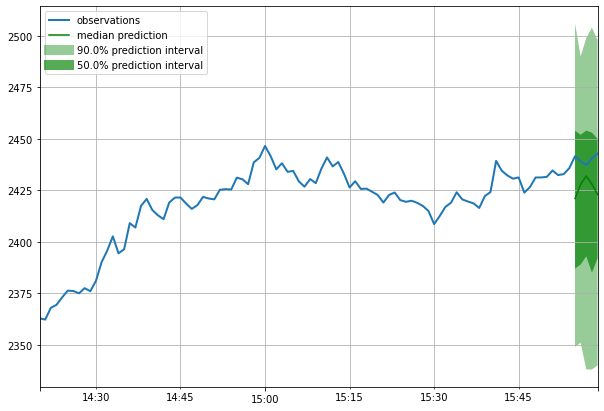

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


2021-05-10 08:38:09.389612 {
    "MSE": 28.81180419921875,
    "abs_error": 38.75,
    "abs_target_sum": 13075.25,
    "abs_target_mean": 2615.05,
    "seasonal_error": 3.59695304576572,
    "MASE": 2.1546013810558873,
    "MAPE": 0.0029626306146383285,
    "sMAPE": 0.0029570063576102256,
    "OWA": NaN,
    "MSIS": 55.324603203886646,
    "QuantileLoss[0.1]": 67.45,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 38.75,
    "Coverage[0.5]": 0.6,
    "QuantileLoss[0.9]": 69.94999999999997,
    "Coverage[0.9]": 1.0,
    "RMSE": 5.367662824658303,
    "NRMSE": 0.0020526042808582255,
    "ND": 0.002963614462438577,
    "wQuantileLoss[0.1]": 0.005158601173973729,
    "wQuantileLoss[0.5]": 0.002963614462438577,
    "wQuantileLoss[0.9]": 0.005349802107034281,
    "mean_absolute_QuantileLoss": 58.71666666666666,
    "mean_wQuantileLoss": 0.004490672581148863,
    "MAE_Coverage": 0.09999999999999998
}


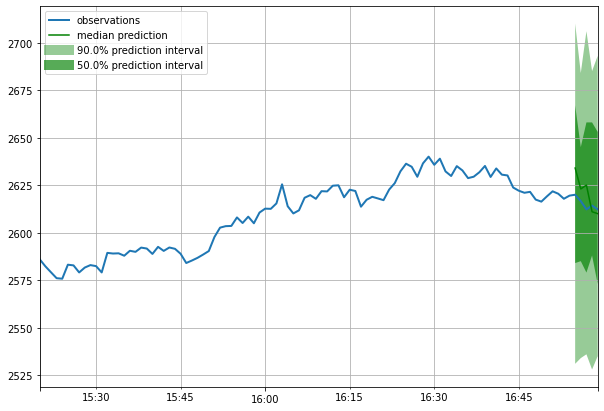

In [10]:
#
# Evaluate and visualize the prediction
#
import json

from gluonts.evaluation import Evaluator, MultivariateEvaluator

for test_dataset in test_datasets:
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_dataset,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    forecast_entry = forecasts[0]
    tss = list(ts_it)

    # LOGGER.log(f"Number of sample paths: {forecast_entry.num_samples}")
    # LOGGER.log(f"Dimension of samples: {forecast_entry.samples.shape}")
    # LOGGER.log(f"Start date of the forecast window: {forecast_entry.start_date}")
    # LOGGER.log(f"Frequency of the time series: {forecast_entry.freq}")

    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_dataset))

    LOGGER.log(json.dumps(agg_metrics, indent=4))
    item_metrics.head()

    plot_prob_forecasts(tss, forecasts)

In [ ]:
#
# NOTE: FURTHER CELLS ARE COMPATIBLE WITH AWS SAGEMAKER ONLY, LOCAL MODE WILL NOT WORK
# Hyperparameter tune the model
#

from ml.tune import Tune

TUNE = Tune(UTILS, LOGGER)

train_dataset_uri = f"{dataset_dir_uri}/{config.TRAIN_DATASET_FILENAME}"
test_dataset_uri = f"{dataset_dir_uri}/{config.TEST_DATASET_FILENAME}"

# Note: Feel free to tune the tuner, i.e. update max number of jobs and hyperparameters. Default is 10 jobs, but you
# may want to change this as you refine the model. Additionally, if you find the best model has a parameter at the
# end of the range you gave it, then you should look to move that range to determine if the model performs better
# along that vector
tuner = TUNE.create_tuner(estimator)
TUNE.fit_tuner(tuner, dataset_dir_uri)

In [ ]:
#
# Get updates for Hyperparameter tune job. Ensure this is completed before going to the next cell
#

TUNE.get_tune_job_update()

In [ ]:
#
# Evaluate the metrics of the tune job
#

TUNE.report_job_analytics()
